<a href="https://colab.research.google.com/github/SourLemon23/brain-tumor-diagnosis/blob/master/brain_tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Google Drive directories
training_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/Training'
testing_dir  = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/Testing'
# Local machine directories
# training_dir = r'brain_tumor_image_set/training'
# testing_dir  = r'brain_tumor_image_set/testing'

# Prediction samples
glioma_path = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/Tumor Samples/Glioma/Glioma_1.jpeg'
meningioma_path = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/Tumor Samples/Meningioma/Meningioma_1.jpeg'
pituitary_path = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/Tumor Samples/Pituitary/Pituitary_1.jpg'
normal_path = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/Tumor Samples/Normal/Normal_1.jpeg'

num_classes = 4
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

train_samples = 2870
test_samples = 394
epochs = 1
batch_size = 20


# Augment data
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)


# Create data generators
train_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

test_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [225]:
# Create a CNN/Sequential model
def create_model():
    model = Sequential()

    model.add(ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape = input_shape))
    model.add(Dropout(0.5))

    model.add(Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    return model


# Print an overall summary of the model
def print_model_summary(model):
    model.summary()


# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


# Train the model
def fit_model(model):
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=(train_samples / batch_size),
        validation_data=test_generator,
        validation_steps=(test_samples / batch_size))
    
    return history


# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


# Classify a tumor from an MRI scan
def classify_tumor(model, img_path):
    img = load_img(
        img_path,
        target_size=target_size)
    
    plt.imshow(img)

    img_array = img_to_array(img)
    print("NumPy array info:", type(img_array))
    print("type:",img_array.dtype)
    print("shape:",img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # img_array = np.array(img_array)
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    # network_guess = decode_predictions(predictions, top=1)
    # network_guess = decode_predictions(predictions)
    # print(predictions)

    # print(img_array)
    
    # print(f'Network Prediction: {network_guess}')
    # print(‘Network Prediction: ', network_guess)

In [226]:
model = create_model()
print_model_summary(model)
compile_model(model)

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
dropout_123 (Dropout)        (None, 5, 5, 2048)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 5, 5, 16)          294928    
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 3, 3, 16)          64        
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 2, 2, 32)        

144/143 [==============================] - 33s 231ms/step - loss: 0.7148 - accuracy: 0.7418 - val_loss: 1.5715 - val_accuracy: 0.2665


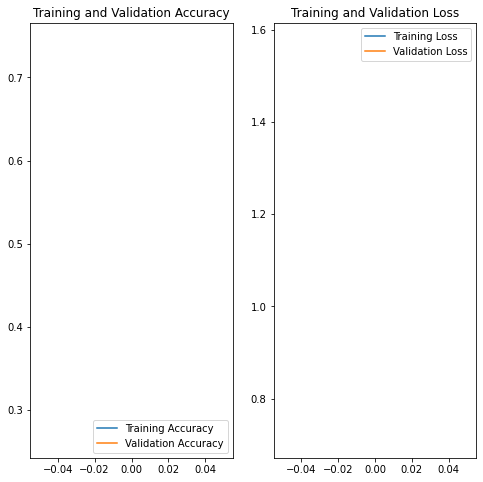

In [227]:
history = fit_model(model)
evaluate_model(history)

NumPy array info: <class 'numpy.ndarray'>
type: float32
shape: (150, 150, 3)


ValueError: ignored

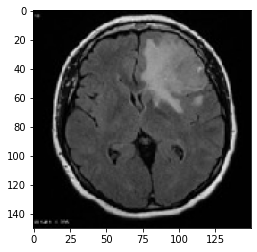

In [228]:
classify_tumor(model, glioma_path)